This script was written by Ammaar Melethil starting on 2023-12-23

In [1]:
!pip install kaggle

In [2]:
# Configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# CIFAR-10 Dataset api
!kaggle competitions download -c cifar-10

cifar-10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Extracting from the zip file
from zipfile import ZipFile
dataset = 'cifar-10.zip'

with ZipFile(dataset, 'r') as zip:
    zip.extractall()
    print('Extraction complete')

Extraction complete


In [5]:
!ls

Cifar10ObjectRecognition.ipynb test.7z
README.md                      train
cifar-10.zip                   train.7z
kaggle.json                    trainLabels.csv
sampleSubmission.csv


We want the images in 'train.7z', we extract using py7zr

In [6]:
!pip install py7zr

  Using cached Brotli-1.1.0-cp38-cp38-macosx_10_9_x86_64.whl.metadata (5.5 kB)
Using cached Brotli-1.1.0-cp38-cp38-macosx_10_9_x86_64.whl (446 kB)
  Attempting uninstall: brotli
    Found existing installation: Brotli 1.0.9
    Uninstalling Brotli-1.0.9:
      Successfully uninstalled Brotli-1.0.9


In [7]:
import py7zr
archive = py7zr.SevenZipFile('train.7z', mode='r')
archive.extractall()
archive.close()

In [8]:
!ls

Cifar10ObjectRecognition.ipynb test.7z
README.md                      train
cifar-10.zip                   train.7z
kaggle.json                    trainLabels.csv
sampleSubmission.csv


Now that the images are extracted, we can begin processing the data

In [9]:
# Importing the dependencies
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

In [10]:
filenames = os.listdir('train')

Labels Processing

In [11]:
labels_df = pd.read_csv('trainLabels.csv')

In [12]:
# Checking if the data is sorted (id in ascending order), I am looking at the first 10 elements
labels_df.head(10)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


In [13]:
# Now, if the last 10 elements are in order
labels_df.tail(10)

,id,label
49990,49991,deer
49991,49992,bird
49992,49993,airplane
49993,49994,automobile
49994,49995,airplane
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile
49999,50000,automobile


In [14]:
# Checking if distribution is even to ensure model can make significant predictions
labels_df['label'].value_counts()

label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64

In [15]:
# Numerically encoding the labels
labels_dictionary = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
labels = [labels_dictionary[i] for i in labels_df['label']]

In [16]:
# Double-checking if encoding was performed correctly
print(labels[0:5])
print(labels[-5:])

[6, 9, 9, 4, 1]
[2, 6, 9, 1, 1]


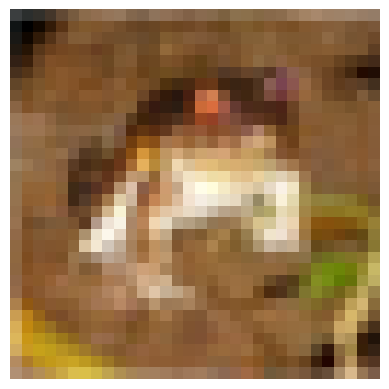

In [17]:
# Taking a look at a sample image
sample_image = Image.open('train/1.png') # Should be a frog
plt.imshow(sample_image)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [18]:
id_list = list(labels_df['id'])

Image Processing

In [19]:
# Converting images to numpy arrays
train_data_folder = 'train/'
data = []

for id in id_list:
    image = Image.open(train_data_folder + str(id) + '.png')
    image = np.array(image)
    data.append(image)

In [20]:
# Checking if conversion was done correctly
print(len(data)) # Should be 50,000
print(type(data[0])) # Should be numpy.ndarray
print(data[0].shape) # Should be 32x32 pixels and RGB (3 color channels) *All images must be the same shape to pass through the neural network*

50000
<class 'numpy.ndarray'>
(32, 32, 3)


In [21]:
# Convert images list and labels list to numpy arrays
X = np.array(data)
Y = np.array(labels)

*Train Test Split*

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2) # Using 20% of images as test data, 80% as training

In [23]:
# Scaling the data 
X_train_scaled = X_train/255 
X_test_scaled = X_test/255

Building the neural network

In [24]:
import tensorflow as tf
from tensorflow import keras

2023-12-27 14:26:35.584802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
n_of_classes = 10

# Setting up the layers of the neural network
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32,32,3)), # 32x32px, RGB
    keras.layers.Dense(64, activation='relu'), # 64 neurons to efficiently maximize RAM usage, Rectified linear units
    keras.layers.Dense(n_of_classes, activation='softmax') # Since nOfClasses > 2 we use 'softmax' not 'sigmoid'
])

2023-12-27 14:26:39.753232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
# Compiling the neural network
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])

In [27]:
# Training the neural network
model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=10) # Model will try to find the relationship between labels (Y_train) and images (X_train_scaled), Model will go through data 10 times

Epoch 1/10
1125/1125 [==============================] - 4s 4ms/step - loss: 1.9489 - acc: 0.3008 - val_loss: 1.8396 - val_acc: 0.3352
Epoch 2/10
1125/1125 [==============================] - 2s 2ms/step - loss: 1.8309 - acc: 0.3468 - val_loss: 1.7938 - val_acc: 0.3517
Epoch 3/10
1125/1125 [==============================] - 2s 1ms/step - loss: 1.7847 - acc: 0.3638 - val_loss: 1.7864 - val_acc: 0.3582
Epoch 4/10
1125/1125 [==============================] - 2s 2ms/step - loss: 1.7456 - acc: 0.3771 - val_loss: 1.7265 - val_acc: 0.3762
Epoch 5/10
1125/1125 [==============================] - 2s 2ms/step - loss: 1.7303 - acc: 0.3832 - val_loss: 1.7346 - val_acc: 0.3742
Epoch 6/10
1125/1125 [==============================] - 2s 1ms/step - loss: 1.7085 - acc: 0.3899 - val_loss: 1.7099 - val_acc: 0.3895
Epoch 7/10
1125/1125 [==============================] - 2s 2ms/step - loss: 1.6891 - acc: 0.3930 - val_loss: 1.6670 - val_acc: 0.4038
Epoch 8/10
1125/1125 [==============================] - 2s 1ms

Was able to achieve accuracy of ~= 40% (not ideal). Now, moving on to transfer learning technique using ResNet50

In [28]:
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers

In [29]:
convolutional_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3)) # ResNet50 needs images in size 256x256 px

In [30]:
model = models.Sequential()
model.add(layers.UpSampling2D(size=(2,2))) # Converting from 32x32 px to 64x64 px
model.add(layers.UpSampling2D(size=(2,2))) # Converting from 64x64 px to 128x128 px
model.add(layers.UpSampling2D(size=(2,2))) # Converting from 128x128 px to 256x256 px -- We now have a compatible image size for use with ResNet50 
model.add(convolutional_base)
model.add(layers.Flatten()) # Convert matrix to vector so all values are in the form of a single column
model.add(layers.BatchNormalization()) # Even though we already scaled data we still do this so performance increases
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5)) # Turn off a few neurons so model does not over-fit
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(n_of_classes, activation='softmax')) # Output layer

In [31]:
# model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [32]:
# history = model.fit(X_train, Y_train, validation_split=0.1, epochs=10)